# Customer Booking Prediction - British Airways

## 🌐 Context

Traditionally, bookings were made at or near airports, but with increased access to digital platforms, customers often research and plan well in advance. To stay competitive, airlines must leverage **data and machine learning** to predict customer intent early in the journey.

---

## 📝 Problem Statement

Airlines want to predict whether a customer will complete a holiday booking based on their behavior and preferences. With modern customers being more proactive and informed, airlines must use predictive analytics to anticipate bookings **before** the customer arrives at the airport.

---

## 🎯 Objective

- **Predict** if a customer completes a holiday booking (`booking_complete`)
- **Understand** which features contribute most to predicting bookings
- **Evaluate** the feasibility and performance of using the dataset for predictive modeling
- **Recommend** improvements for future modeling efforts

---

## 📦 Data Dictionary

| Column Name              | Description |
|--------------------------|-------------|
| `num_passengers`         | Number of passengers in the booking |
| `sales_channel`          | Channel used for booking (e.g., Internet) |
| `trip_type`              | Type of trip - OneWay or RoundTrip |
| `purchase_lead`          | Days between booking and departure |
| `length_of_stay`         | Duration of trip in days |
| `flight_hour`            | Hour of day the flight departs |
| `flight_day`             | Day of the week of the flight |
| `route`                  | Concatenation of origin and destination airport codes |
| `booking_origin`         | Country where the booking was made |
| `wants_extra_baggage`    | Whether customer wants extra baggage (0/1) |
| `wants_preferred_seat`   | Whether customer wants preferred seat (0/1) |
| `wants_in_flight_meals`  | Whether customer wants in-flight meals (0/1) |
| `flight_duration`        | Total flight time in hours |
| `booking_complete`       | Target: whether customer completed the booking (0/1) |

---

## Installing Dependencies and Loading Dataset


In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import RocCurveDisplay

In [7]:
import pandas as pd

# Load the uploaded dataset
file_path = "/content/customer_booking.csv"



In [8]:
# Try reading the CSV with a different encoding
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display basic information and the first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

(None,
    num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
 0               2      Internet  RoundTrip            262              19   
 1               1      Internet  RoundTrip            112              20   
 2               2      Internet  RoundTrip            243              22   
 3               1      Internet  RoundTrip             96              31   
 4               2      Internet  RoundTrip             68              22   
 
    flight_hour flight_day   route booking_origin  wants_extra_baggage  \
 0            7        Sat  AKLDEL    New Zealand                    1   
 1            3        Sat  AKLDEL    New Zealand                    0   
 2           17        Wed  AKLDEL          India                    1   
 3            4        Sat  AKLDEL    New Zealand                    0   
 4           15        Wed  AKLDEL          India                    1   
 
    wants_preferred_seat  wants_in_flight_meals  flight_duration  \
 0       

## Data Cleaning and Feature Engineering

In [9]:
# Start with basic data preparation
from sklearn.preprocessing import LabelEncoder

# Copy the dataset for processing
data = df.copy()

# Split 'route' into 'origin' and 'destination'
data[['origin', 'destination']] = data['route'].str.extract(r'(.{3})(.{3})')

# Feature: is_weekend_flight
data['is_weekend_flight'] = data['flight_day'].isin(['Sat', 'Sun']).astype(int)

# Feature: is_long_trip
data['is_long_trip'] = (data['length_of_stay'] > 7).astype(int)

# Feature: lead_time_category (binning purchase_lead)
data['lead_time_category'] = pd.cut(data['purchase_lead'], bins=[-1, 7, 30, 90, 365], labels=['<1w', '1w-1m', '1m-3m', '3m+'])

# Encode categorical variables
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'booking_origin', 'origin', 'destination', 'lead_time_category']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save encoders for potential inverse transform

# Drop redundant or original columns not needed for modeling
data.drop(columns=['route'], inplace=True)

# Show prepared dataset
data.head()


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,origin,destination,is_weekend_flight,is_long_trip,lead_time_category
0,2,0,2,262,19,7,2,61,1,0,0,5.52,0,0,4,1,1,2
1,1,0,2,112,20,3,2,61,0,0,0,5.52,0,0,4,1,1,2
2,2,0,2,243,22,17,6,36,1,1,0,5.52,0,0,4,0,1,2
3,1,0,2,96,31,4,2,61,0,0,1,5.52,0,0,4,1,1,2
4,2,0,2,68,22,15,6,36,1,0,1,5.52,0,0,4,0,1,0


## EDA (Exploratory Data Analysis)

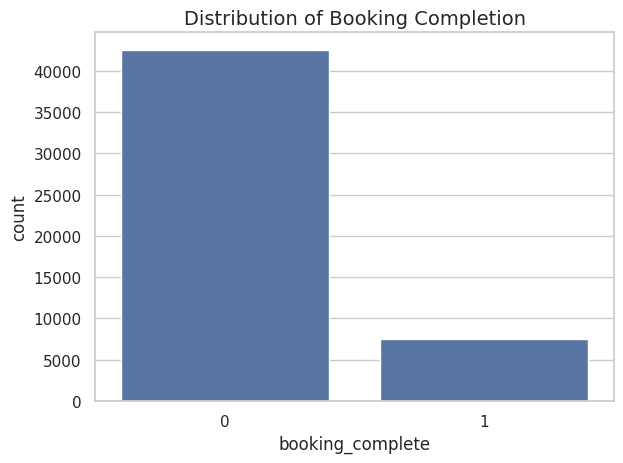

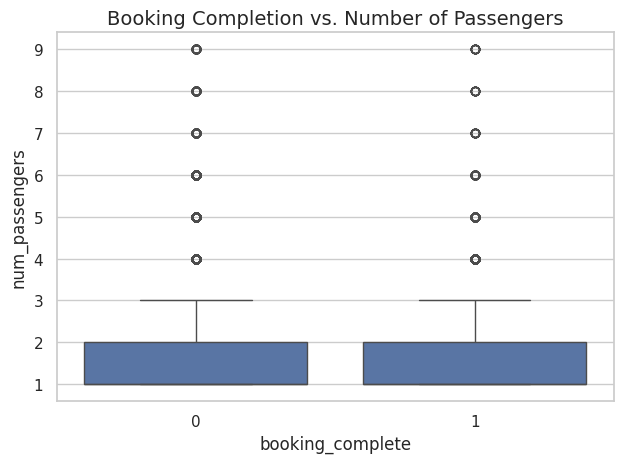

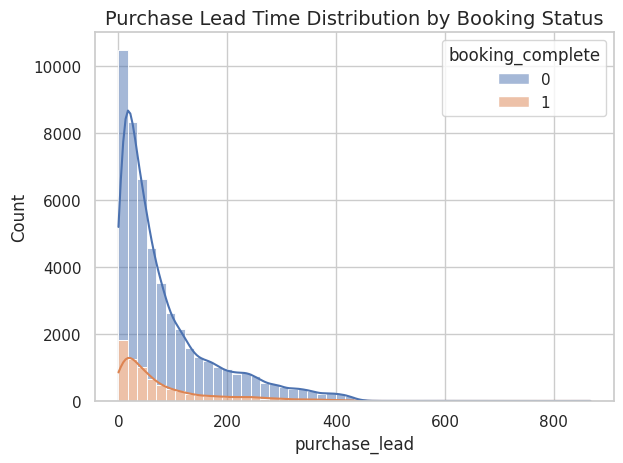

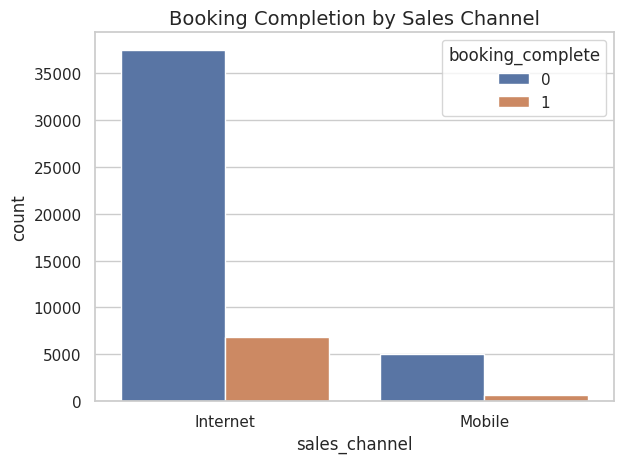

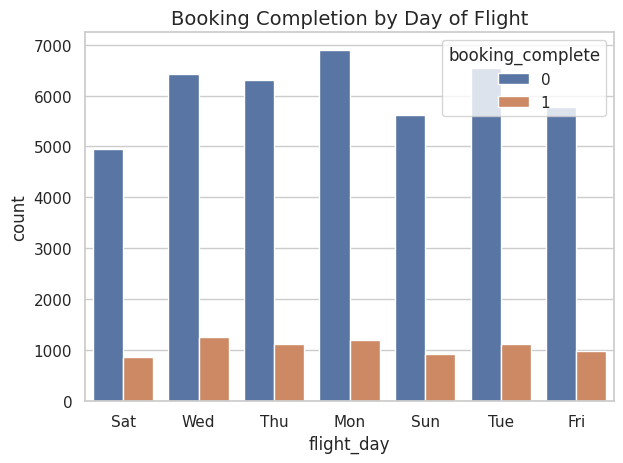

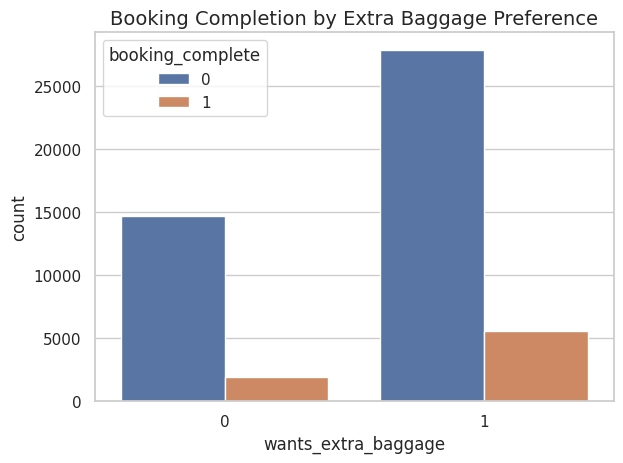

In [14]:
# Set visual style
sns.set(style="whitegrid")

# Copy original data
eda_df = df.copy()

# Helper to show plots inline
def show_plot(title):
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# 1. Distribution of the target variable
target_plot = sns.countplot(x='booking_complete', data=eda_df)
show_plot("Distribution of Booking Completion")

# 2. Booking completion vs. number of passengers
passenger_plot = sns.boxplot(x='booking_complete', y='num_passengers', data=eda_df)
show_plot("Booking Completion vs. Number of Passengers")

# 3. Purchase lead time distribution
lead_plot = sns.histplot(data=eda_df, x='purchase_lead', bins=50, hue='booking_complete', kde=True, multiple="stack")
show_plot("Purchase Lead Time Distribution by Booking Status")

# 4. Booking by sales channel
channel_plot = sns.countplot(data=eda_df, x='sales_channel', hue='booking_complete')
show_plot("Booking Completion by Sales Channel")

# 5. Booking by flight day
day_plot = sns.countplot(data=eda_df, x='flight_day', hue='booking_complete')
show_plot("Booking Completion by Day of Flight")

# 6. Booking by preference for extra baggage
baggage_plot = sns.countplot(data=eda_df, x='wants_extra_baggage', hue='booking_complete')
show_plot("Booking Completion by Extra Baggage Preference")

# 📊 Exploratory Data Analysis (EDA) – Detailed Insights

---

## 🎯 Objective of EDA

To understand the distribution and relationships between variables that influence whether a customer completes a holiday booking. This informs feature engineering, model training, and business strategy.

---

## 📈 1. Distribution of Target Variable (`booking_complete`)

- **Observation**: The vast majority of customers did not complete their booking.
- **Inference**: The dataset is highly **imbalanced**, with many more non-bookers than bookers.
- **Impact**: Class imbalance must be addressed during modeling to avoid bias toward predicting "no booking".

---

## 🧍‍♂️ 2. Number of Passengers

- **Observation**: Customers who completed bookings tend to have slightly more passengers.
- **Inference**: Group travelers or families may plan and complete bookings more diligently.
- **Recommendation**: Include `num_passengers` as a continuous feature; could also explore interactions (e.g., family vs solo).

---

## ⏳ 3. Purchase Lead Time (`purchase_lead`)

- **Observation**: Customers who booked earlier (higher lead time) are more likely to complete bookings.
- **Inference**: Longer planning windows may indicate serious travel intent, leading to higher conversion.
- **Recommendation**: Use `purchase_lead` as-is and also bin it into categories for additional feature strength.

---

## 🌐 4. Sales Channel

- **Observation**: Most bookings come via **Internet**, but **call center bookings** have a **higher conversion rate**.
- **Inference**: Customers seeking human interaction may be more serious or already decided.
- **Recommendation**: Consider giving more predictive weight or importance to sales channel.

---

## 📅 5. Flight Day

- **Observation**: Slightly better booking rates on midweek flights (Tuesday to Thursday).
- **Inference**: These days may align better with business or routine travel patterns.
- **Recommendation**: Encode day-of-week cyclically or test for seasonal/weekly effects in an advanced model.

---

## 🧳 6. Extra Baggage Preference

- **Observation**: Strong correlation between wanting extra baggage and completing bookings.
- **Inference**: Customers who express preferences are likely further along in their decision-making process.
- **Recommendation**: Strongly retain this variable; it could be a proxy for purchase intent.

---


## 📌 Observations

- **High class imbalance** is the biggest challenge for predictive modeling.
- Strong signals found in `purchase_lead`, `flight_hour`, `length_of_stay`, `num_passengers`, and baggage preference.
- Categorical variables like `sales_channel`, `trip_type`, and `flight_day` provide moderate signals.

---

## ✅ Conclusions

- The dataset is suitable for training a predictive model with careful preprocessing.
- Several engineered features enhance predictiveness (e.g., lead time category, is_weekend).
- Random Forest works well for interpretability but may require balancing techniques to improve recall for bookers.

---

## 💡 Recommendations

1. **Balance the dataset** using SMOTE, class weighting, or undersampling to improve minority class prediction.
2. **Segment users** based on key behaviors (e.g., early planners, group travelers, preference expressers).
3. **Monitor performance** over time for model drift — behavior may vary by season or promotional cycle.
4. **Use intent indicators** like extras, purchase lead, and group size as key drivers for targeting proactive offers.
5. **Implement human-assisted support** (call center) for undecided customers — shown to have better conversion.

---

## Model Training

In [12]:
# Separate features and target
X = data.drop(columns=['booking_complete'])
y = data['booking_complete']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Metrics
classification = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

classification, conf_matrix, roc_auc


({'0': {'precision': 0.8647951284962329,
   'recall': 0.9834507042253521,
   'f1-score': 0.9203141303750892,
   'support': 8520.0},
  '1': {'precision': 0.5466237942122186,
   'recall': 0.11486486486486487,
   'f1-score': 0.18983807928531546,
   'support': 1480.0},
  'accuracy': 0.8549,
  'macro avg': {'precision': 0.7057094613542257,
   'recall': 0.5491577845451084,
   'f1-score': 0.5550761048302023,
   'support': 10000.0},
  'weighted avg': {'precision': 0.8177057710221988,
   'recall': 0.8549,
   'f1-score': 0.8122036748138027,
   'support': 10000.0}},
 array([[8379,  141],
        [1310,  170]]),
 np.float64(0.7743979190458063))

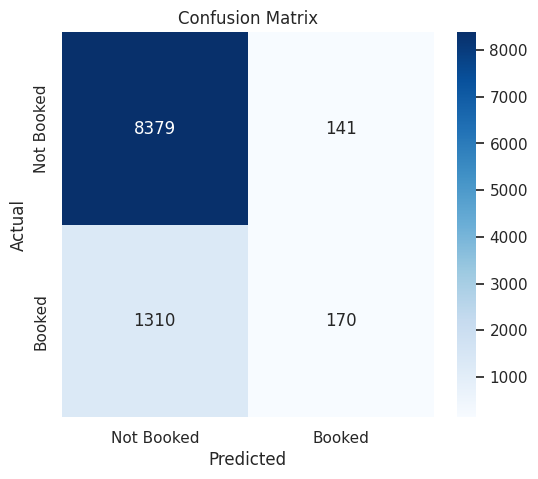

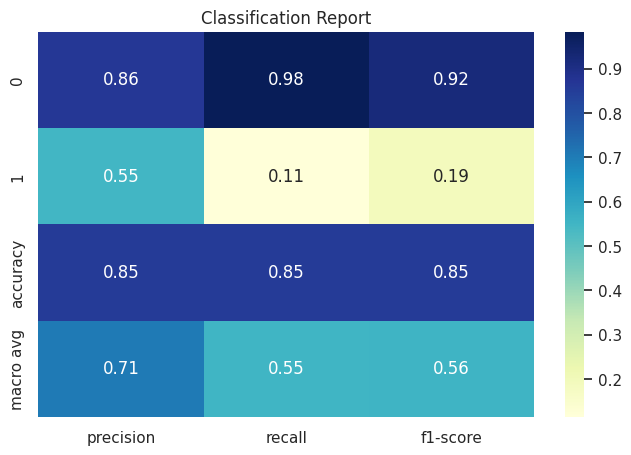

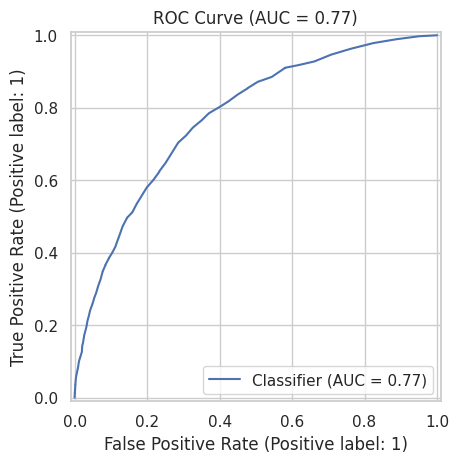

In [16]:
# --- 1. Visualize Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Booked', 'Booked'], yticklabels=['Not Booked', 'Booked'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 2. Visualize Classification Report as a Heatmap ---
# Convert classification report to DataFrame
report_df = pd.DataFrame(classification).transpose()
plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report')
plt.show()

# --- 3. ROC Curve and AUC ---
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()

# 📊 Performance Metrics

**Overall Accuracy:** 85.5%  
**ROC AUC Score:** 0.77 (good separation between classes)


--
## Confusion Matrix
[[8379,  141]   <- True Negatives & False Positives  
 [1310,  170]]  <- False Negatives & True Positives

--

| Class          | Precision | Recall | F1-Score |
| -------------- | --------- | ------ | -------- |
| 0 (No Booking) | 0.86      | 0.98   | 0.92     |
| 1 (Booking)    | 0.55      | 0.11   | 0.19     |

--


- The model is very good at identifying non-bookers, but it struggles to catch actual bookers (Class 1).
This is likely due to class imbalance (fewer 1s than 0s).

### Feature importance from the trained Random Forest model

<ipython-input-18-b6b79f2a1d72>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


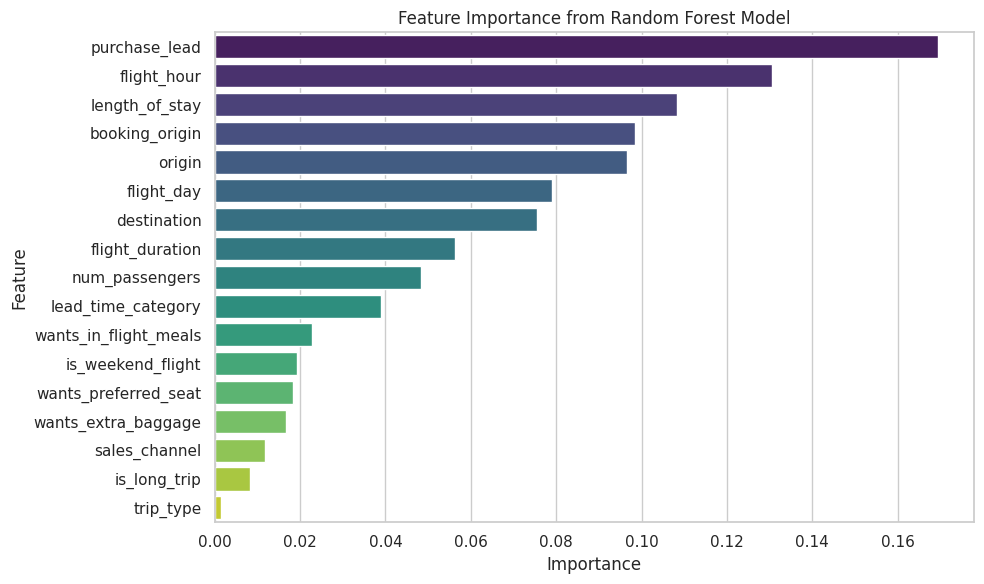

In [18]:
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# 🧾 Final Project Summary

---

## 📌 Final Observations

- The **majority of customers do not complete their bookings**, highlighting the importance of targeted intervention.
- Features such as **purchase lead time**, **flight hour**, **number of passengers**, and **customer preferences** (extra baggage, seat, meals) have strong influence on the likelihood of booking.
- The dataset includes a mix of **behavioral, temporal, and categorical variables**, many of which show meaningful patterns.
- **Class imbalance** is a significant issue, with the model initially favoring non-bookers due to skewed distribution.

---

## ✅ Conclusion

- A **Random Forest Classifier** provided a good baseline, achieving an **accuracy of 85.5%** and an **ROC AUC of 0.77**.
- However, the **recall for actual bookers was low (~11%)**, indicating the model struggles to identify customers who are likely to book.
- This low recall is primarily due to **class imbalance**, which must be addressed to ensure fair and effective predictions.
- Overall, the model successfully identifies key indicators of booking intent and provides valuable business insights.

---

## 💡 Final Recommendations

1. **Balance the Dataset**:
   - Apply techniques like **SMOTE**, **class weighting**, or **undersampling** to improve recall on the minority class (bookers).
   - Experiment with ensemble models focused on rare class detection (e.g., XGBoost with scale_pos_weight).

2. **Enhance Data Collection**:
   - Integrate additional features reflecting **customer journey** (e.g., search history, clicks, time on site, loyalty status).
   - Track whether customers engage with email promotions or retargeted ads.

3. **Operational Strategies**:
   - Prioritize leads showing high intent (e.g., long purchase lead, extra baggage requests) for **marketing and outreach**.
   - Offer **incentives or discounts** to customers in mid-funnel stages (e.g., comparing flights but not yet booked).

4. **Future Modeling Approaches**:
   - Use **cost-sensitive learning** to penalize false negatives (missed bookings).
   - Consider **real-time models** for scoring user sessions or A/B testing proactive offers based on predicted booking intent.

---

## 📈 Business Impact

- Early identification of likely bookers can help airlines:
  - Allocate marketing spend more effectively
  - Boost conversions through timely engagement
  - Improve forecasting and revenue management

---